<div style="color:#8b1538; font-size:28px">Ce jupyter notebook permet la manipulation de fichier PDB en python</div>

- Lecture de fichier .pdb
- Visualisation de structures
- Alignement de séquences
- Comparaison de deux structures: alignement & rmsd
- Carte de contact (contact maps)
- Mode normaux

Il utilise les fonctions mise en place dans le module **prot_py** codé en python (version 3.7.8).

<br>

# Les modules

In [11]:
%%capture

import os
import resource
import time
import matplotlib.pyplot as plt
import numpy as np
import nglview as nv
import pytraj as pt

from prot_py.alignment import alignment as ali
from prot_py.arguments import arguments as arg
from prot_py.files import files as f
from prot_py.maps import maps

<br>

In [2]:
def execution_time(fonction, samples=1000):
    """
    Détermine le temps d'éxécution d'une fonction f donné pour x samples (par ddéfaut 1000).
    """
    execution = []
    for _ in range(samples):
        start_time = time.time()
        fonction
        execution.append(time.time() - start_time)
    return execution

<br>

# Téléchargement & chargement des structures

In [3]:
%%capture
pdb = ["1A01", "2QSP"]
f.fetch_pdb(pdb)
struct = f.load_pdb(pdb)

<br>

> Temps d'éxécution

In [23]:
execution = execution_time(f.fetch_pdb(pdb))
np.mean(execution)

4.267692565917969e-07

In [24]:
%%capture
execution = execution_time(f.load_pdb(pdb))

In [25]:
np.mean(execution)

9.179115295410156e-08

# Visualisation

## 1A01 - hémoglobine humaine

In [15]:
traj = pt.iterload('./data/pdb/{}.pdb'.format(pdb[0]))
view = nv.show_pytraj(traj)
view

NGLWidget()

## 2QSP - hémoglobine bovine

In [16]:
traj = pt.iterload('./data/pdb/{}.pdb'.format(pdb[1]))
view = nv.show_pytraj(traj)
view

NGLWidget()

<br>

# Alignement de séquences

Paramètre de l'alignement:

- **global** - alignement global des deux protéines
- **region** - alignement global des régions

In [17]:
align_param = "global"
alignment = ali.sequences_alignment(struct, align_param)

Alignement global des séquences de 1A01 & 2QSP


In [18]:
ali.print_alignment(alignment)

VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYRMHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPATQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYHVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYRMHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPATQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH
|||.|||.||||||||||.||.|||||||||||||||||||||||||||||||||||||.|||.|||.||.|.||.|.|||.|||||||||||||||||||||.||||||.|||..||||||||||||||.||||||||||| ||.|||.||||.||||.|||||||||||||||||.|||||||||||||.||||.||||||||||||..||.|..|||.||||||.||||||||||||||||.|||||||.|||..|||||||..||..|||||||||||||.|||||.|||.||||||||||.||.|||||||||||||||||||||||||||||||||||||.|||.|||.||.|.||.|.|||.|||||||||||||||||||||.||||||.|||..||||||||||||||.|||||||

> Temps d'éxécution - alignement global

In [26]:
%%capture
execution = execution_time(ali.sequences_alignment(struct, align_param))

In [27]:
np.mean(execution)

8.082389831542969e-08

<br>

In [28]:
align_param = "region"
alignments = ali.sequences_alignment(struct, align_param)

Alignement region des séquences de 1A01 & 2QSP


In [29]:
for align in alignments:
    ali.print_alignment(align)

VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
|||.|||.||||||||||.||.|||||||||||||||||||||||||||||||||||||.|||.|||.||.|.||.|.|||.|||||||||||||||||||||.||||||.|||..||||||||||||||.||||||||||
VLSAADKGNVKAAWGKVGGHAAEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGAKVAAALTKAVEHLDDLPGALSELSDLHAHKLRVDPVNFKLLSHSLLVTLASHLPSDFTPAVHASLDKFLANVSTVLTSKYR
  Score=639

MHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPATQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH
| ||.|||.||||.||||.|||||||||||||||||.|||||||||||||.||||.||||||||||||..||.|..|||.||||||.||||||||||||||||.|||||||.|||..|||||||..||..|||||||||||||.||
M-LTAEEKAAVTAFWGKVKVDEVGGEALGRLLVVYPWTQRFFESFGDLSTADAVMNNPKVKAHGKKVLDSFSNGMKHLDDLKGTFAALSELHCDKLHVDPENFKLLGNVLVVVLARNFGKEFTPVLQADFQKVVAGVANALAHRYH
  Score=624

VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLV

> Temps d'éxécution - alignement de régions

In [30]:
%%capture
execution = execution_time(ali.sequences_alignment(struct, align_param))

In [31]:
np.mean(execution)

8.225440979003906e-08

<br>

# Alignement des structures & RMSD

In [32]:
rmsd, aligned_struct = ali.structures_alignment(struct)

Alignement des structures de 1A01 & 2QSP


In [33]:
print("Le rmsd vaut {:.3f} Angstom".format(rmsd))

Le rmsd vaut 2.918 Angstom


In [34]:
view = nv.show_biopython(aligned_struct)
view

NGLWidget()

> Temps d'éxécution

In [35]:
%%capture
execution = execution_time(ali.structures_alignment(struct))

In [36]:
np.mean(execution)

9.584426879882813e-08

<br>

# Carte de contacts

In [39]:
def plot_contact_map(contact_map, pdb, cutoff):
    """
    Génère le graphe d'une carte de contacts donnée.
    """
    fig, axs = plt.subplots(1, 1, figsize=(12, 10), constrained_layout=True)
    axs.imshow(contact_map, aspect="auto", cmap=plt.cm.gray, interpolation='nearest')

    title = "Carte de contacts de la protéine {} pour un cutoff de {}A".format(pdb, cutoff)
    fig.suptitle(title, fontsize="xx-large")

    plt.show()
    plt.clf()

In [40]:
cutoff = 6
contact_map = maps.compute_contact_map(struct[0], pdb[0], cutoff)

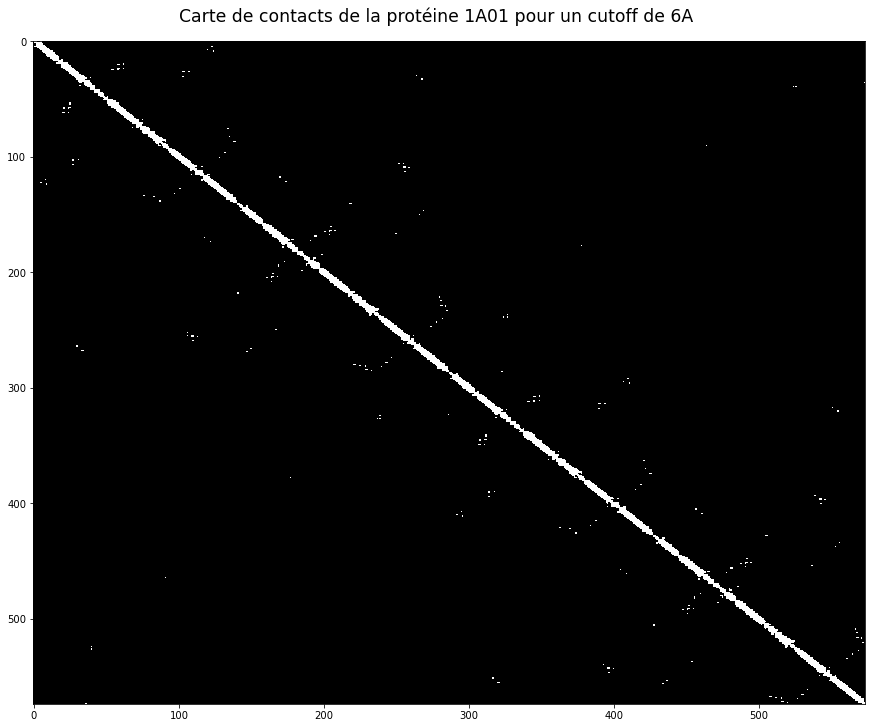

<Figure size 432x288 with 0 Axes>

In [41]:
plot_contact_map(contact_map, pdb[0], cutoff)

<br>

> Temps d'éxécution

In [44]:
execution = {}
for cutoff in range(6,13,2):
    execution[cutoff] = execution_time(maps.compute_contact_map(struct[0], pdb[0], cutoff))

In [49]:
for key, value in execution.items():
    print("Cutoff {:>2}: {}".format(key, np.mean(value)))

Cutoff  6: 8.630752563476562e-08
Cutoff  8: 8.487701416015625e-08
Cutoff 10: 8.630752563476562e-08
Cutoff 12: 8.845329284667969e-08


<br>

In [50]:
cutoff = 6
contact_map = maps.compute_contact_map(struct[1], pdb[1], cutoff)

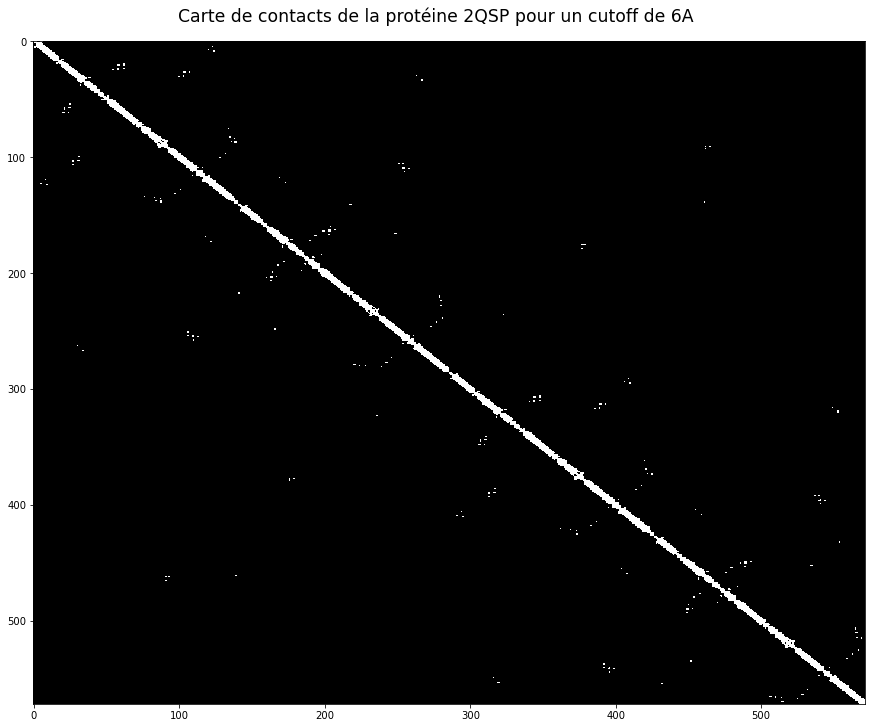

<Figure size 432x288 with 0 Axes>

In [51]:
plot_contact_map(contact_map, pdb[1], cutoff)

<br>

> Temps d'éxécution

In [52]:
execution = {}
for cutoff in range(6,13,2):
    execution[cutoff] = execution_time(maps.compute_contact_map(struct[1], pdb[1], cutoff))

In [53]:
for key, value in execution.items():
    print("Cutoff {:>2}: {}".format(key, np.mean(value)))

Cutoff  6: 1.392364501953125e-07
Cutoff  8: 8.7738037109375e-08
Cutoff 10: 8.511543273925781e-08
Cutoff 12: 8.7738037109375e-08


<br>
<br>

# 2G33

Capside du virus de l'hépatite B (HBV) avec T=4, i.e. la capside de HBV est constitué de 240 monomère de HBc soit 120 dimères.

La structure de la macromolécule a été obtenue par x-ray diffraction et a une résolution de 3.96A.

La macromolécule est constituée de 588 résidues & 4658 atomes.

In [55]:
%%capture
pdb = ["2G33"]
f.fetch_pdb(pdb)
struct = f.load_pdb(pdb)

<br>

> Temps d'éxécution

In [56]:
execution = execution_time(f.fetch_pdb(pdb))
np.mean(execution)

4.172325134277344e-07

In [57]:
%%capture
execution = execution_time(f.load_pdb(pdb))

In [58]:
np.mean(execution)

1.1992454528808594e-07

<br>

## Visualisation

In [59]:
traj = pt.iterload('./data/pdb/{}.pdb'.format(pdb[0]))
view = nv.show_pytraj(traj)
view

NGLWidget()

<br>

## Carte de contacts

In [60]:
cutoff = 10
contact_map = maps.compute_contact_map(struct[0], pdb[0], cutoff)

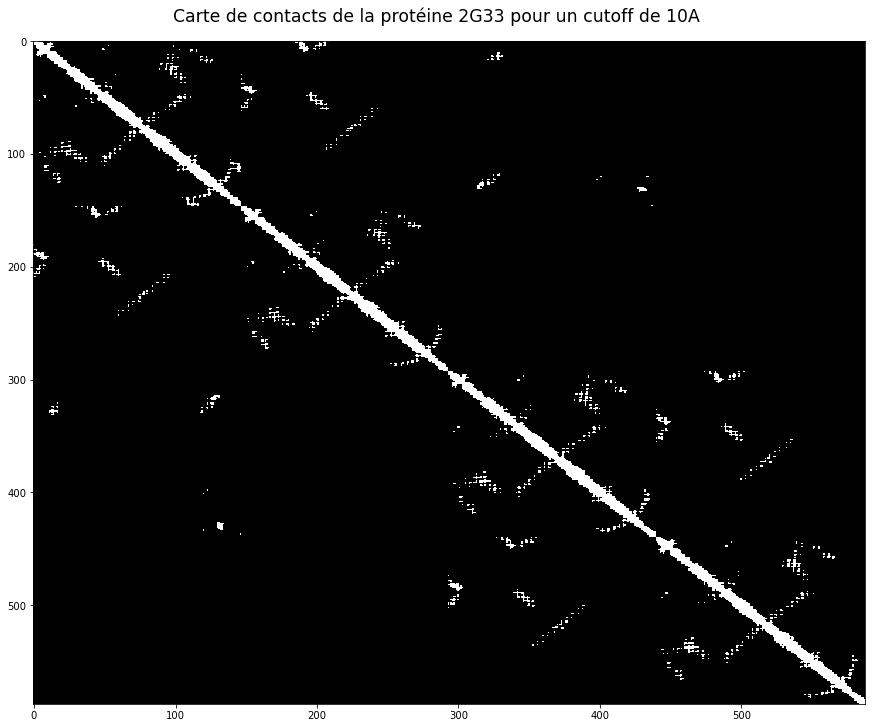

<Figure size 432x288 with 0 Axes>

In [61]:
plot_contact_map(contact_map, pdb[0], cutoff)

<br>
<br>

> Temps d'éxécution

In [62]:
execution = {}
for cutoff in range(6,13,2):
    execution[cutoff] = execution_time(maps.compute_contact_map(struct[0], pdb[0], cutoff))

In [63]:
for key, value in execution.items():
    print("Cutoff {:>2}: {}".format(key, np.mean(value)))

Cutoff  6: 8.58306884765625e-08
Cutoff  8: 9.632110595703126e-08
Cutoff 10: 1.1372566223144531e-07
Cutoff 12: 8.58306884765625e-08


<br>

# 1HTQ

Structure cristallographique multicopie d'une glutamine synthétase détendue.

La structure de la macromolécule a été obtenu par x-ray diffraction et a une résolution de 2.40A.

L'assemblage est constitué de 11 448 résidues & 97 872 atomes.

In [64]:
%%capture
pdb = ["1HTQ"]
f.fetch_pdb(pdb)
struct = f.load_pdb(pdb)

<br>

> Temps d'éxécution

In [65]:
execution = execution_time(f.fetch_pdb(pdb))
np.mean(execution)

2.808570861816406e-07

In [66]:
%%capture
execution = execution_time(f.load_pdb(pdb))

In [69]:
np.mean(execution)

8.678436279296875e-08

<br>

## Visualisation

In [70]:
traj = pt.iterload('./data/pdb/{}.pdb'.format(pdb[0]))
view = nv.show_pytraj(traj)
view

NGLWidget(max_frame=9)

# Carte de contacts

In [71]:
cutoff = 6
contact_map = maps.compute_contact_map(struct[0], pdb[0], cutoff)

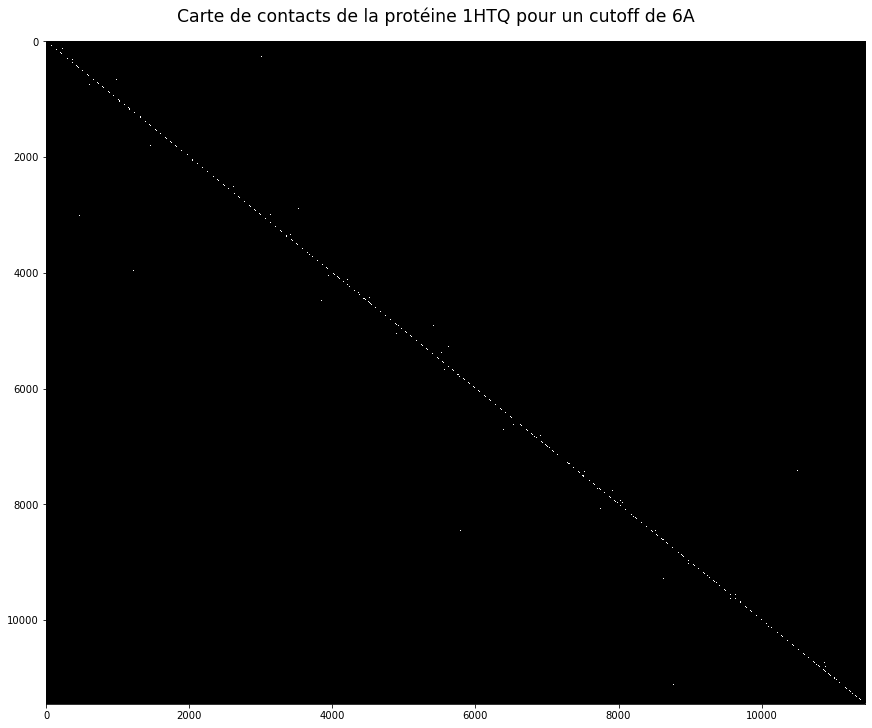

<Figure size 432x288 with 0 Axes>

In [72]:
plot_contact_map(contact_map, pdb[0], cutoff)

<br>
<br>

> Temps d'éxécution

In [73]:
execution = {}
for cutoff in range(6,13,2):
    execution[cutoff] = execution_time(maps.compute_contact_map(struct[0], pdb[0], cutoff))

In [76]:
for key, value in execution.items():
    print("Cutoff {:>2}: {}".format(key, np.mean(value)))

Cutoff  6: 1.8739700317382813e-07
Cutoff  8: 1.1491775512695312e-07
Cutoff 10: 8.678436279296875e-08
Cutoff 12: 8.177757263183594e-08


In [77]:
s = time.time()
maps.compute_contact_map(struct[0], pdb[0], cutoff)
print(time.time() - s)

1076.1408643722534
